# 频繁模式与关联规则挖掘
- 对数据集进行处理，转换成适合进行**关联规则**挖掘的形式；
- 找出频繁模式；
- 导出关联规则，计算其支持度和置信度;
- 对规则进行评价，可使用Lift、卡方和其它教材中提及的指标, 至少2种；
- 对挖掘结果进行分析；
- 可视化展示。

GitHub:https://github.com/Lakehikaru/MovieRecommendationSystem4DataMining/blob/main/peer2.ipynb

In [83]:
import numpy as np
from scipy import stats
#import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth

## Wine Reviews

首先读入葡萄酒数据集，并且展示其数据维度。其中可以看到葡萄酒的产地以及酒厂，葡萄品种，得分，价格等信息，因此可以考虑进行关联规则挖掘，找出哪些国家的酒厂，哪些品种的葡萄产出评分更高的葡萄酒。

In [84]:
df_wine = pd.read_csv("./wine/winemag-data_first150k.csv",delimiter=',',low_memory=False)
df_wineInfo = df_wine[['country', 'variety', 'winery', 'price', 'points']]
df_wineInfo = df_wineInfo.astype(str)
print(df_wineInfo.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   country  150930 non-null  object
 1   variety  150930 non-null  object
 2   winery   150930 non-null  object
 3   price    150930 non-null  object
 4   points   150930 non-null  object
dtypes: object(5)
memory usage: 5.8+ MB
None


去除完缺失值之后，可以对数据的大致分布进行可视化来从而获取直观上的取值范围

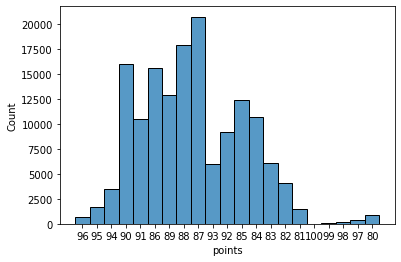

In [85]:
ptsPlot = sns.histplot(df_wineInfo['points'],bins=20)


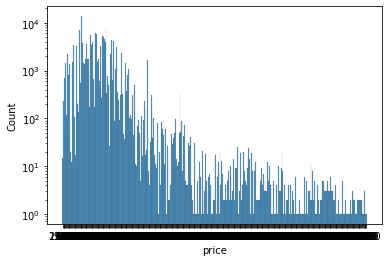

In [86]:
pricePlot = sns.histplot(df_wineInfo['price'],bins=200)
pricePlot.set_yscale('log')

由以上图观察可知，价格的分布与得分的分布相关性没有达到很强，这证明价格对得分的影响没有想象中的那么强。

要寻找频繁模式，需要将数据集处理成合适的属性。我们规定选取的属性为：['country', 'points', 'variety', 'winery', 'price']。接下来提取以上的属性并且将数据集转换成列表数组格式。

In [87]:
df_wineInfo_te = df_wineInfo.stack().groupby(level=0).apply(list).tolist()
te = TransactionEncoder()
te_ary = te.fit(df_wineInfo_te).transform(df_wineInfo_te)
df = pd.DataFrame(te_ary, columns=te.columns_)
df

,'37 Cellars,1+1=3,10 Knots,10.0,100,100.0,1000 Stories,1000.0,101.0,102.0,...,Ébano,Écluse,Élevée Winegrowers,Éric & Jöel Durand,Ñandú,Único Luis Miguel,àMaurice,áster,Štoka,Žilavka
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150925,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
150926,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
150927,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
150928,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


将数据整理好之后可以开始寻找频繁模式，这里使用了FP-growth算法。

In [88]:
freqItemSet = fpgrowth(df, min_support=0.001, use_colnames=True)
freqItemSet

,support,itemsets
0,0.413417,(US)
1,0.084808,(Cabernet Sauvignon)
2,0.004605,(96)
3,0.054780,(Spain)
4,0.001564,(110.0)
...,...,...
1937,0.003936,"(Italy, Prosecco)"
1938,0.001106,"(Prosecco, 87)"
1939,0.001020,"(Prosecco, 86)"
1940,0.001106,"(Italy, Prosecco, 87)"


接下来计算关联规则,使用mlxtend中的关联规则库可以得到关联规则，并且计算了其置信度和支持度。与此同时，lift和leverage这两个评价指标也被计算出来了。

In [89]:
from mlxtend.frequent_patterns import association_rules

ar = association_rules(freqItemSet, metric="confidence", min_threshold=0.6)
ar

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Cabernet Sauvignon),(US),0.084808,0.413417,0.060810,0.717031,1.734403,0.025749,2.072961
1,"(Cabernet Sauvignon, 90)",(US),0.008885,0.413417,0.006818,0.767338,1.856088,0.003145,2.521180
2,"(Cabernet Sauvignon, 86)",(US),0.007984,0.413417,0.005002,0.626556,1.515555,0.001702,1.570739
3,"(Cabernet Sauvignon, 89)",(US),0.006096,0.413417,0.004015,0.658696,1.593297,0.001495,1.718651
4,"(87, Cabernet Sauvignon)",(US),0.010528,0.413417,0.006944,0.659534,1.595325,0.002591,1.722885
...,...,...,...,...,...,...,...,...,...
408,"(Sangiovese Grosso, 91)",(Italy),0.001126,0.155556,0.001126,1.000000,6.428571,0.000951,inf
409,"(Sangiovese Grosso, 90)",(Italy),0.001100,0.155556,0.001100,1.000000,6.428571,0.000929,inf
410,(Prosecco),(Italy),0.003936,0.155556,0.003936,1.000000,6.428571,0.003323,inf
411,"(Prosecco, 87)",(Italy),0.001106,0.155556,0.001106,1.000000,6.428571,0.000934,inf


<AxesSubplot:xlabel='lift', ylabel='Count'>

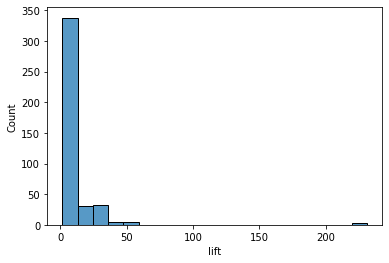

In [90]:
sns.histplot(ar['lift'],bins=20)

<AxesSubplot:xlabel='leverage', ylabel='Count'>

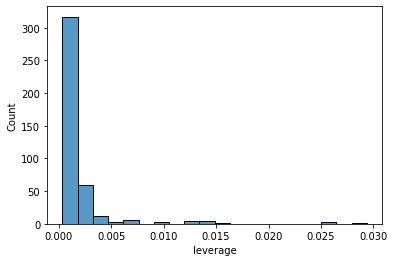

In [91]:
sns.histplot(ar['leverage'],bins=20)

可以看到，lift和leverage值过高的数据往往是地名与酒厂这种强相关的结构。接下来可以通过限制lift指标再次挖掘关联规则。

In [92]:
ar_lift = association_rules(freqItemSet, metric="lift", min_threshold=5)
ar_lift_modified = ar_lift[(ar_lift['lift'] > 5) & (ar_lift['lift'] < 15) &(ar_lift['confidence'] > 0.5)]
ar_lift_modified.sort_values(by='antecedents', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,"(Bordeaux-style Red Blend, 95)",(France),0.001458,0.139787,0.001093,0.750000,5.365319,0.000889,3.440853
535,(Grillo),(Italy),0.001000,0.155556,0.001000,1.000000,6.428571,0.000845,inf
548,"(Williams Selyem, US)",(Pinot Noir),0.002478,0.094686,0.001637,0.660428,6.974905,0.001402,2.666042
522,(Champagne Blend),(France),0.008202,0.139787,0.007315,0.891761,6.379442,0.006168,7.947344
498,(Joseph Drouhin),(France),0.001252,0.139787,0.001252,1.000000,7.153759,0.001077,inf
...,...,...,...,...,...,...,...,...,...
253,"(US, 54.0)",(Pinot Noir),0.001656,0.094686,0.001199,0.724000,7.646303,0.001042,3.280122
249,"(89, Nebbiolo)",(Italy),0.001623,0.155556,0.001590,0.979592,6.297376,0.001338,41.377778
245,"(90, Nebbiolo)",(Italy),0.002372,0.155556,0.002372,1.000000,6.428571,0.002003,inf
213,(Nebbiolo),(Italy),0.014848,0.155556,0.014510,0.977242,6.282272,0.012200,37.105882


如上所示，意大利酒厂使用的Prosecco品种葡萄得分在86-87之间，而法国的Bordeaux-style Red Blend葡萄得分在95左右，是更好的酿酒葡萄选择。